# K-Means Clustering Implementation   
## Liam Quinlan
CS 339   
Dr. Kretchmar

### Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import os.path


datadir = "data"

### K-Means function

In [2]:
def kmeans(data, k):
    # Initialization
    centers = np.zeros((k,data.shape[1]))
    new_centers = np.zeros((k,data.shape[1]))
    distances = np.ones((k,data.shape[0]))

    sample_indices = np.random.choice(data.shape[0], k, replace=False)
    centers = data[sample_indices]
    # print("Centers:\n", centers, "\n")

    # Learning
    for _ in range(20):
        # Compute Distances
        for x in range(k):
            for y in range(0,data.shape[0]):
                distance = np.linalg.norm(centers[x] - data[y])
                distances[x][y] = distance
        # print("Distances:\n", distances)

        # Identify closest clusters
        clusters = np.argmin(distances,axis=0)
        # print("Clusters:\n", clusters)

        # Update centers
        for z in range(k):
            new_centers[z] = np.array(data[clusters == z].mean(axis=0))
        # print("New Centers:\n", new_centers, "\n")

        # Check for repeat centers
        does_array_repeat = centers == new_centers
        if np.all(does_array_repeat) == True:
            break

        centers = new_centers

    return centers, clusters

In [3]:
def normalize(data):
    normalized_columns = []

    for x in range(0,data.shape[1]):
        column = data[:,x]

        min = np.min(column)
        column = column - min

        max = np.max(column)
        column = column / max

        normalized_columns.append(column)

    normalized_data = np.stack(normalized_columns, axis=1)

    return normalized_data

In [4]:
def standardize(data):
    standardized_columns = []

    for x in range(0,data.shape[1]):
        column = data[:,x]

        mean = np.mean(column)
        st_dev = np.std(column)

        column = (column - mean) / st_dev

        standardized_columns.append(column)

    standardized_data = np.stack(standardized_columns, axis=1)

    return standardized_data

In [5]:
# def calculate_mse(data, centers, clusters):
#     average_standard_error_list = []
#     cluster_size_list = []

#     # calculate mse for each cluster
#     for x in range(0,centers.shape[0]):        
#         data_by_cluster = data[clusters == x]
#         cluster_size = data_by_cluster.shape[0]

#         deviations = data_by_cluster - centers[x]
#         variances = np.var(deviations, axis=0)

#         standard_errors = np.sqrt(variances) / np.sqrt(cluster_size)

#         average_standard_error = np.mean(standard_errors)

#         average_standard_error_list.append(average_standard_error)
#         cluster_size_list.append(cluster_size)

#     # calculate weighted average of mses
#     for y in range(len(cluster_size_list)):
#         average_standard_error_list[y] = average_standard_error_list[y] * cluster_size_list[y]

#     std_err_sum = np.sum(average_standard_error_list)
    
#     mean_standard_error = std_err_sum / data.shape[0]
        
#     return mean_standard_error

In [6]:
def calculate_mse(data, centers, clusters):
    average_squared_error_list = []
    cluster_size_list = []

    # calculate mse for each cluster
    for x in range(0,centers.shape[0]):
        data_by_cluster = data[clusters == x]
        cluster_size = data_by_cluster.shape[0]

        errors = data_by_cluster - centers[x]
        squared_errors = errors * errors

        mean_squared_error = np.mean(squared_errors)

        average_squared_error_list.append(mean_squared_error)
        cluster_size_list.append(cluster_size)

    # calculate weighted average of mses
    for y in range(len(cluster_size_list)):
        average_squared_error_list[y] = average_squared_error_list[y] * cluster_size_list[y]

    squared_error_sum = np.sum(average_squared_error_list)

    mse = squared_error_sum / data.shape[0]

    return mse

In [7]:
def kmeans_wrapper(data, k, n):
    mse_list = np.empty(0)
    centers_list = []
    
    for _ in range(n):
        centers, clusters = kmeans(data, k)
        mse = calculate_mse(data, centers, clusters)
        mse_list = np.append(mse_list, mse)
        centers_list.append(centers)
        
        print("MSE: ", mse)
        print("Centers:\n", centers, "\n")

    min_mse_index = np.argmin(mse_list)
    min_mse = np.min(mse_list)
    best_centers = centers_list[min_mse_index]

    return min_mse, best_centers

In [8]:
def elbow_plot(data, n):
    k_vs_mse_list = np.empty((0,2)) 

    for k in range(1, n+1):
        centers, clusters = kmeans(data, k)
        mse = calculate_mse(data, centers, clusters)
        k_vs_mse = np.array([k, mse])
        k_vs_mse_list = np.append(k_vs_mse_list, [k_vs_mse], axis=0)

    print(k_vs_mse_list)

    plt.scatter(k_vs_mse_list[:,0], k_vs_mse_list[:,1])
    plt.show()

    return

### Testing K-Means on a small dataset

In [9]:
# initialize data
data1 = np.array([[1,2],[1,3],[1,5],[2,3],[2,1],[6,7],[5,6],[5,9],[7,6],[8,6]])
print(data1)

[[1 2]
 [1 3]
 [1 5]
 [2 3]
 [2 1]
 [6 7]
 [5 6]
 [5 9]
 [7 6]
 [8 6]]


In [10]:
centers, clusters = kmeans(data1, 2)

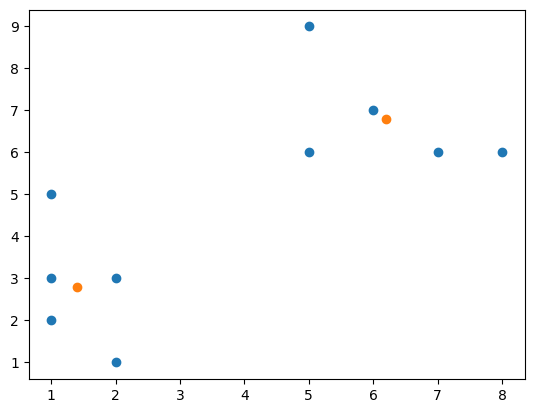

In [11]:
plt.scatter(data1[:, 0], data1[:, 1])
plt.scatter(centers[:, 0], centers[:, 1])

plt.show()

### Performing Cluster Analysis on S&P500 market data to encourage portfolio diversification

In [12]:
def readData(filepath):
    file = open(filepath, 'r')

    LoL = []

    for line in file:
        vals = line.strip().split(',')
        temp_list = []
        for val in vals:
            temp_list.append(val)
        LoL.append(temp_list)

    file.close()

    return LoL

In [13]:
listOfLists = readData(os.path.join(datadir, "financials.csv"))

financialsDF = pd.DataFrame(listOfLists[1:], columns=listOfLists[0])

financialsDF

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week High,52 Week Low,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.3328617,7.92,259.77,175.49,138721055226,9048000000,4.3902707,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.1479592,1.7,68.39,48.925,10783419933,601000000,3.5754826,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.9089824,0.26,64.6,42.28,102121042306,5744000000,3.7404804,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.4995599,3.29,125.86,60.05,181386347059,10310000000,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.7144699,5.44,162.6,114.82,98765855553,5643228000,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,Industrials,70.24,30.94,1.1700794,1.83,76.81,46.86,12915021000,722000000,2.7262094,5.31,http://www.sec.gov/cgi-bin/browse-edgar?action...
501,YUM,Yum! Brands Inc,Consumer Discretionary,76.3,27.25,1.7970798,4.07,86.93,62.85,27003303098,2289000000,6.3136363,212.08,http://www.sec.gov/cgi-bin/browse-edgar?action...
502,ZBH,Zimmer Biomet Holdings,Health Care,115.53,14.32,0.7948336,9.01,133.49,108.17,24454698119,2007400000,3.1648953,2.39,http://www.sec.gov/cgi-bin/browse-edgar?action...
503,ZION,Zions Bancorp,Financials,50.71,17.73,1.480933,2.6,55.61,38.43,10670678640,0,3.7945793,1.42,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [14]:
financialsDFClean = financialsDF.copy()

columns_to_drop = ["Symbol","Name","Sector","Price","Price/Earnings","Earnings/Share","52 Week Low","52 Week High","EBITDA","Price/Sales","Price/Book","SEC Filings"]
financialsDFClean.drop(columns_to_drop, axis=1, inplace=True)

lf = lambda string_to_float: float(string_to_float)
financialsDFClean["Dividend Yield"] = financialsDFClean["Dividend Yield"].apply(lf)
financialsDFClean["Market Cap"] = financialsDFClean["Market Cap"].apply(lf)

financialsDFClean

,Dividend Yield,Market Cap
0,2.332862,1.387211e+11
1,1.147959,1.078342e+10
2,1.908982,1.021210e+11
3,2.499560,1.813863e+11
4,1.714470,9.876586e+10
...,...,...
500,1.170079,1.291502e+10
501,1.797080,2.700330e+10
502,0.794834,2.445470e+10
503,1.480933,1.067068e+10


In [15]:
financials_array = financialsDFClean.to_numpy()
financials_array = normalize(financials_array)

print(financials_array)

[[0.18425287 0.16866774]
 [0.09066752 0.01010968]
 [0.15077426 0.12330793]
 ...
 [0.06277713 0.02705302]
 [0.11696628 0.00996995]
 [0.05389475 0.04135055]]


[[1.00000000e+00 1.35710219e-02]
 [2.00000000e+00 9.70163887e-03]
 [3.00000000e+00 6.37282098e-03]
 [4.00000000e+00 4.36255537e-03]
 [5.00000000e+00 4.07498629e-03]
 [6.00000000e+00 3.86770267e-03]
 [7.00000000e+00 2.92189430e-03]
 [8.00000000e+00 3.07429265e-03]
 [9.00000000e+00 2.48925621e-03]
 [1.00000000e+01 2.50943407e-03]
 [1.10000000e+01 3.30103070e-03]
 [1.20000000e+01 3.08410118e-03]
 [1.30000000e+01 3.85905032e-03]
 [1.40000000e+01 2.05743405e-03]
 [1.50000000e+01 1.58489289e-03]
 [1.60000000e+01 2.44285859e-03]
 [1.70000000e+01 2.00201618e-03]
 [1.80000000e+01 2.41417539e-03]
 [1.90000000e+01 1.99521267e-03]
 [2.00000000e+01 1.06114524e-03]
 [2.10000000e+01 2.08840616e-03]
 [2.20000000e+01 1.66107561e-03]
 [2.30000000e+01 1.07393287e-03]
 [2.40000000e+01 7.57322610e-04]
 [2.50000000e+01 9.83308667e-04]
 [2.60000000e+01 1.49935910e-03]
 [2.70000000e+01 8.85809049e-04]
 [2.80000000e+01 1.01884791e-03]
 [2.90000000e+01 1.47411808e-03]
 [3.00000000e+01 8.89830666e-04]]


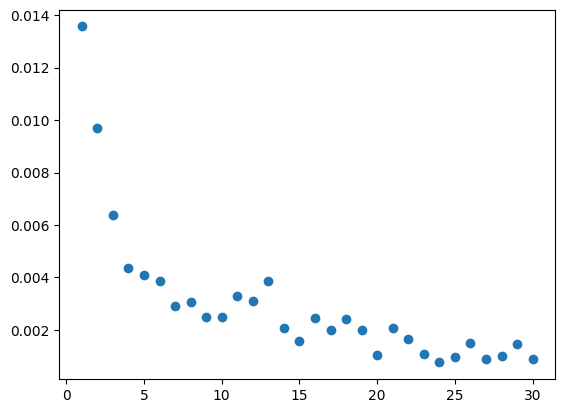

In [16]:
elbow_plot(financials_array, 30)

In [17]:
centers, clusters = kmeans(financials_array, 10)

print(centers)

[[0.07217837 0.08503907]
 [0.17091608 0.335052  ]
 [0.20406647 0.04043267]
 [0.10409962 0.01285526]
 [0.07344072 0.02335067]
 [0.43761613 0.04165735]
 [0.00533308 0.01967685]
 [0.25659231 0.02794704]
 [0.29408423 0.01837945]
 [0.1475304  0.03434365]]


In [18]:
best_mse, best_centers = kmeans_wrapper(financials_array, 10, 10)

MSE:  0.003005266728899483
Centers:
 [[0.00507524 0.02620228]
 [0.14858768 0.0304597 ]
 [0.18094057 0.08048685]
 [0.26867867 0.16057352]
 [0.21611446 0.01520144]
 [0.26193184 0.01935384]
 [0.19126309 0.01381552]
 [0.40869337 0.02277733]
 [0.08812767 0.03083244]
 [0.11849254 0.42322313]] 

MSE:  0.0017904836609099037
Centers:
 [[0.14666531 0.03034549]
 [0.0842159  0.02687877]
 [0.00482821 0.02933538]
 [0.71386808 0.14853367]
 [0.2036028  0.02777424]
 [0.42891231 0.02470296]
 [0.27366089 0.23691481]
 [0.16344799 0.14462207]
 [0.27725466 0.02270713]
 [0.08041054 0.62348076]] 

MSE:  0.002301882804984307
Centers:
 [[0.43089368 0.02258945]
 [0.27763456 0.02195377]
 [0.00331563 0.0204123 ]
 [0.07521261 0.02823128]
 [0.15949491 0.57918104]
 [0.16597066 0.04565542]
 [0.21440503 0.02219968]
 [0.12737538 0.0286033 ]
 [0.21348835 0.17513292]
 [0.03158632 0.16680829]] 

MSE:  0.0032322887490724354
Centers:
 [[5.57740830e-02 2.96470778e-02]
 [3.83185549e-01 2.38028733e-02]
 [3.03798655e-03 6.586412

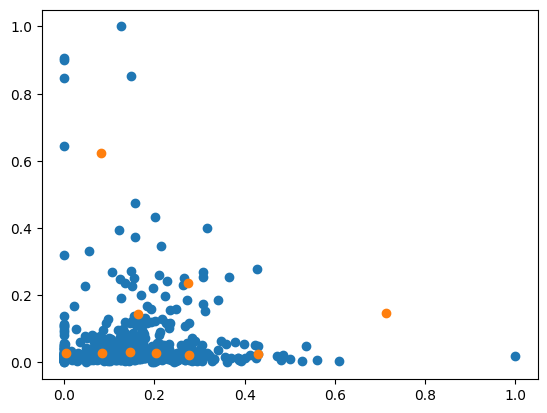

In [19]:
plt.scatter(financials_array[:, 0], financials_array[:, 1])
plt.scatter(best_centers[:,0], best_centers[:,1])

plt.show()